In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import sklearn.metrics
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Analysis of sc-mixology dataset

This notebook shows the analysis of a cell mixture profiled by chromium 10x, as a part of the sc-mixology dataset. Data are parsed directly from the original repository.

In [2]:
sc.settings.verbosity=2
sc.set_figure_params(dpi_save=300)

In [3]:
# load the data and create the AnnData object
tdata = pd.read_table("https://github.com/LuyiTian/sc_mixology/raw/master/data/csv/sc_10x_5cl.count.csv.gz", sep=",")
metadata = pd.read_table("https://github.com/LuyiTian/sc_mixology/raw/master/data/csv/sc_10x_5cl.metadata.csv.gz", sep=",")
adata = anndata.AnnData(tdata.T)

metadata_cols = ['cell_line', 'cell_line_demuxlet', 'demuxlet_cls']
adata.obs = metadata.loc[:, metadata_cols]
for c in metadata_cols:
    adata.obs.loc[:, c] = pd.Categorical(adata.obs.loc[:, c])

Data are processed and filtered using widely-accepted parameters

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.05, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.05, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']
    finished (0:00:07)


Here we calculate the PCA embedding

In [5]:
sc.tl.pca(adata)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:00)


We build here different kNN graphs, using a different number of PCs and neighbors. Also, Leiden clustering is performed at decreasing resolutions.
(Output is suppressed here...)

In [ ]:
res = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1][::-1]
for n_pcs in [10, 20, 30, 40, 50]:
    for n_neighbors in range(5, 35, 5):
        sc.pp.neighbors(adata, n_pcs=n_pcs, n_neighbors=n_neighbors)
        sc.tl.umap(adata)
        for x in range(len(res)):
            sc.tl.leiden(adata, resolution=res[x], key_added=f'leiden_level_{1 + x}')
        schist.inference.nested_model(adata, n_init=3, equilibrate=False, random_seed=42, deg_corr=True)
        schist.io.write(adata, prefix=f'Tian/Tian_pc{n_pcs}_n{n_neighbors}_dcTrue')

Once all results have been saved, load and look at conconrdance with given annotations

In [7]:
pcs = [10, 20, 30, 40, 50]
neighbors = range(5, 35, 5)
ARI_n = pd.DataFrame(0., index = neighbors, columns=pcs)
ARI_l = pd.DataFrame(0., index = neighbors, columns=pcs)
for n_pcs in pcs:
    for n_neighbors in neighbors:
        adata = schist.io.read(f"Tian/Tian_pc{n_pcs}_n{n_neighbors}_dcTrue")
        leiden_cols = [x for x in adata.obs_keys() if x.startswith('leiden_level')]
        nsbm_cols = [x for x in adata.obs_keys() if x.startswith('nsbm_level')]
        nsbm_ARI = np.array([sklearn.metrics.adjusted_rand_score(adata.obs.cell_line, adata.obs[x]) for x in nsbm_cols])
        ARI_n.loc[n_neighbors, n_pcs] = np.max(nsbm_ARI)
        leiden_ARI = np.array([sklearn.metrics.adjusted_rand_score(adata.obs.cell_line, adata.obs[x]) for x in leiden_cols])
        ARI_l.loc[n_neighbors, n_pcs] = np.max(leiden_ARI)

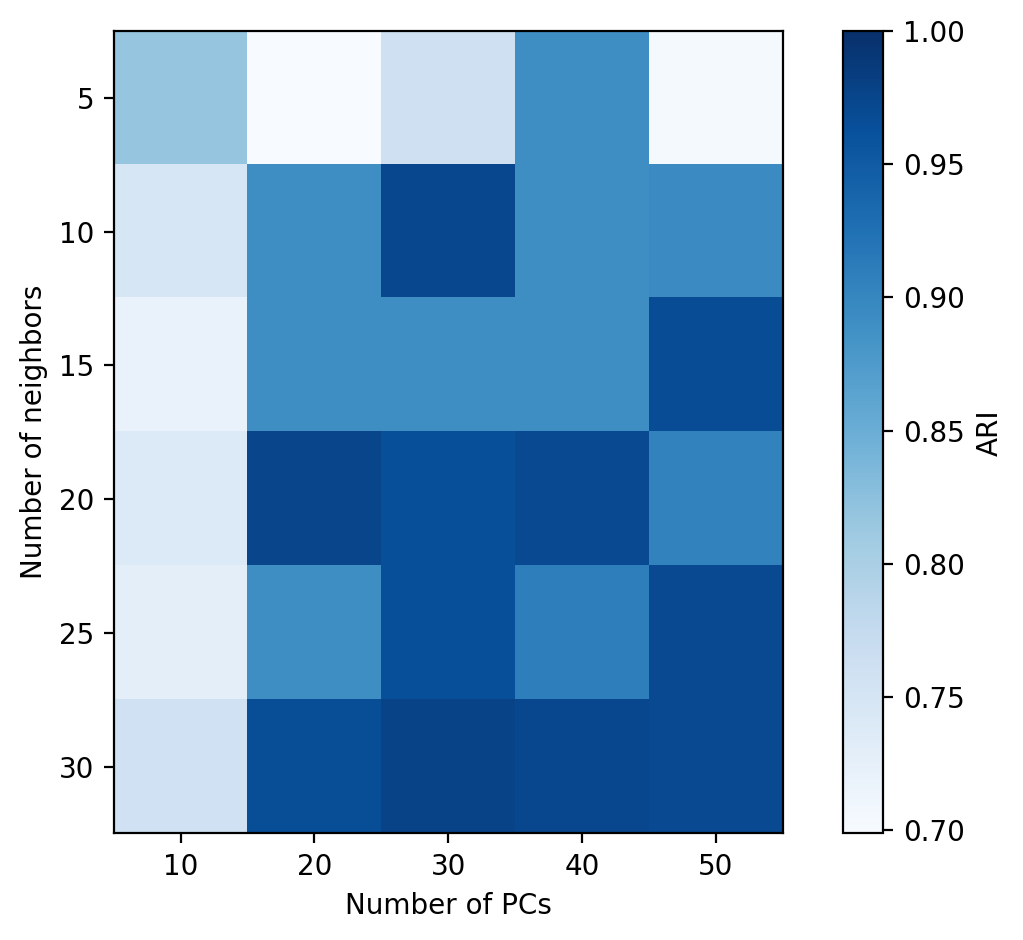

In [10]:
plt.rcdefaults()
mmin = np.min([np.min(ARI_n.values), np.min(ARI_l.values)])
imshow(ARI_n, cmap="Blues", vmin=mmin, vmax=1)
xticks(range(len(pcs)), pcs)
yticks(range(len(neighbors)), neighbors)
xlabel("Number of PCs")
ylabel("Number of neighbors")
colorbar(label="ARI", )
tight_layout()

We here take the 30 PC and 30 neighbor dataset

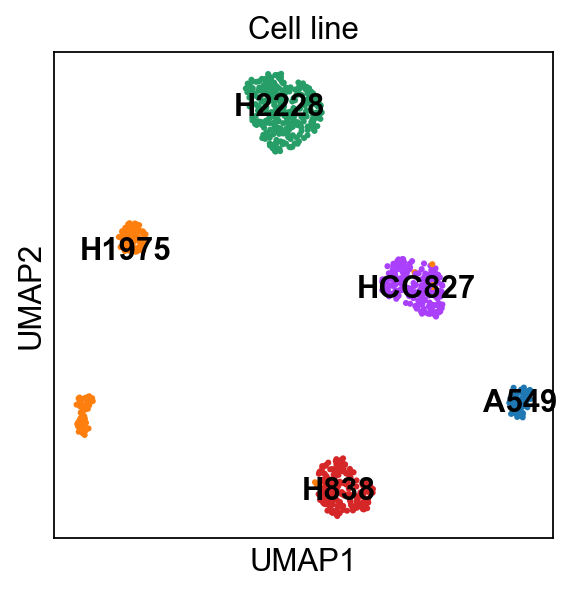

In [11]:
sc.set_figure_params(dpi_save=300)
adata = schist.io.read(f"Tian/Tian_pc30_n30_dcTrue")
sc.pl.umap(adata, color=['cell_line'], ncols=2, legend_loc='on data', title="Cell line", size=30)

Here we show the hierarchy as alluvial plot

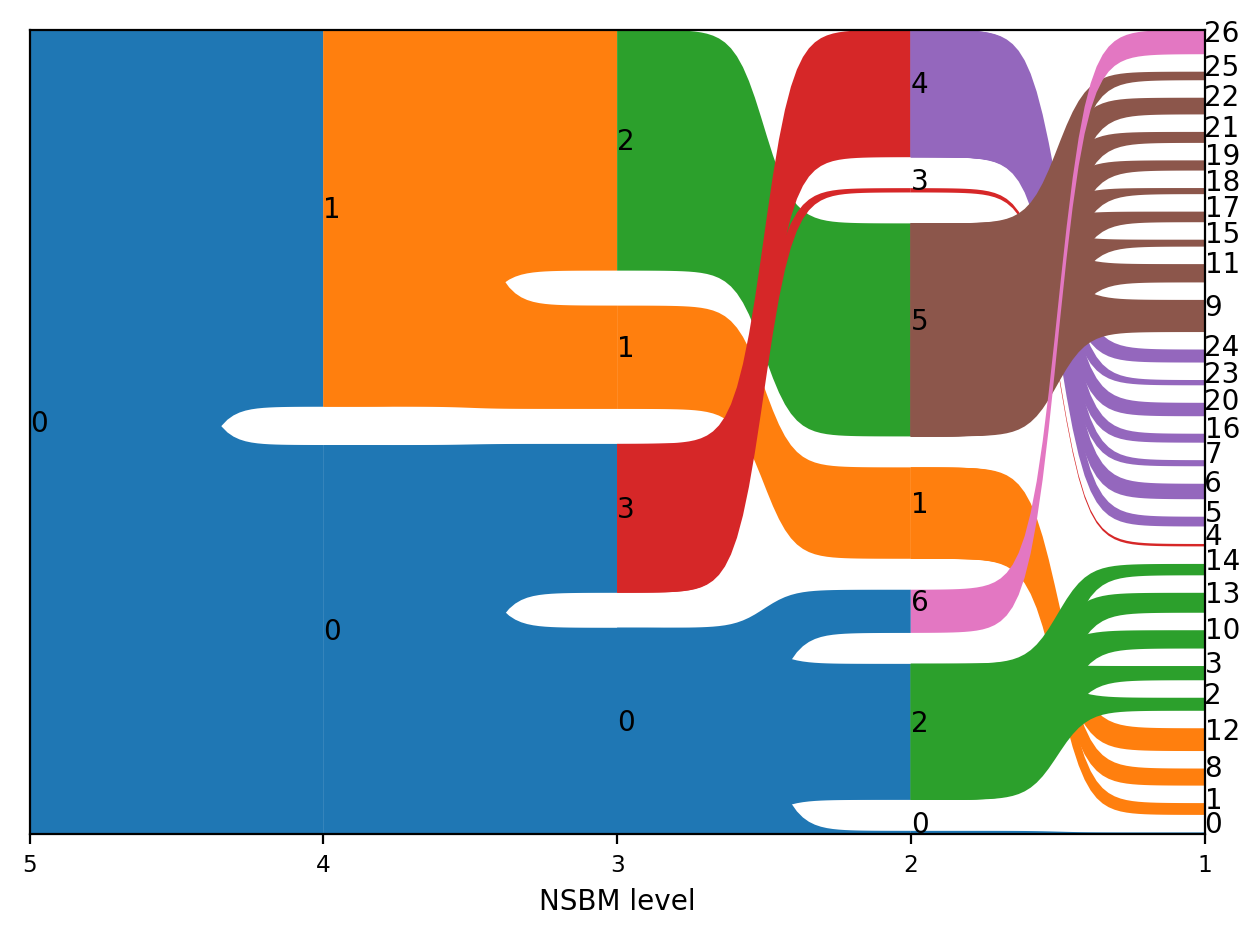

In [12]:
plt.rcdefaults()

schist.pl.alluvial(adata, level_start=1, level_end=5 )
xticks(range(5), [5, 4, 3, 2, 1], size='small')
tight_layout()

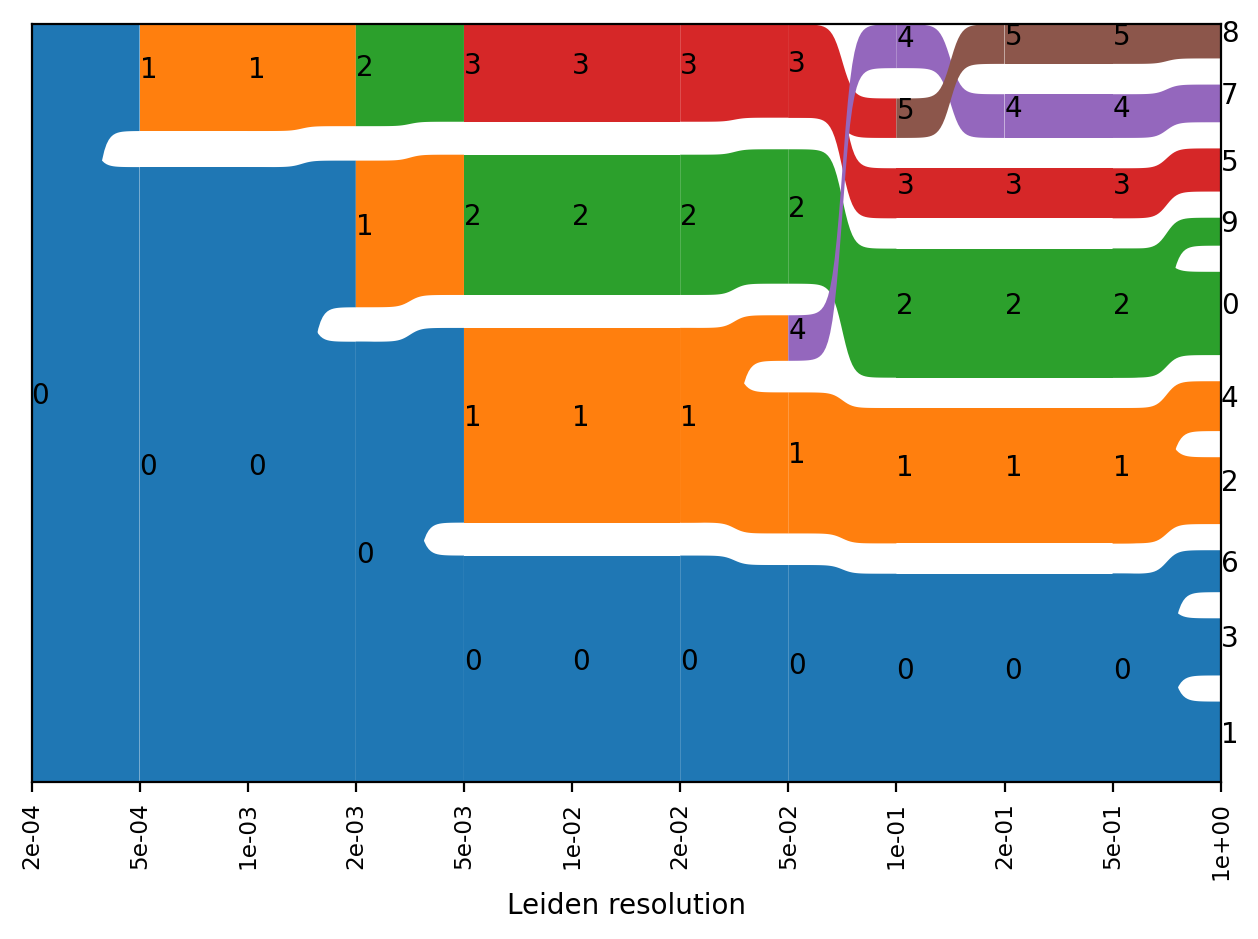

In [13]:
res = [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1][::-1]
schist.pl.alluvial(adata, key='leiden', level_start=1, level_end=12)
xlabel("Leiden resolution")
xticks(range(12), [f'{x:.0e}' for x in res[::-1][1:]], rotation=90, size='small')
tight_layout()